In [44]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.neighbors import KernelDensity

# Initial analysis of Apple quotes
When searching for Apple quotes, we must discard food-related quotes while including quotes about Apple Inc. Therefore, we will use a rule-based approach, where we have a list of indicator words that decide whether to include a quotation. This way, we will be left with a filtered dataset containing mostly quotations related to the company Apple. This also enables us to utilize more extensive filtration algorithms, which would be too costly to run on the entire dataset. We have created a data preprocessing pipeline, which as a result has created a csv-file for each year, consisting only of Apple-related quotes.

Let's first load this data, as well as the relevant dates of the Apple product launches.


In [67]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

#List of dates for the apple events
apple_event_dates_str=["2015-03-09","2015-06-10","2015-09-09",
"2016-03-21","2016-06-15","2016-09-07", "2016-10-27",
"2017-06-07", "2017-09-12",
"2018-03-27","2018-06-06", "2018-09-12", "2018-10-30",
"2019-03-25","2019-06-05","2019-09-10","2019-12-02",
"2020-06-24","2020-09-15","2020-10-13","2020-11-10"]

#apple_event_dates_pd = pd.DataFrame({'Date':[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]})
apple_event_dates=[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]

In [71]:
df

,quoteID,quotation,speaker,date,numOccurrences
0,2020-03-29-000118,... Zane Lowe checks in via FaceTime with Elto...,None,2020-03-29 17:47:52,1
1,2020-02-13-007205,Apple prices generally peak in January. Betwee...,Sarah Johnson,2020-02-13 10:01:48,3
2,2020-01-23-044076,"I'm not sure why Apple did this,",Roger Grimes,2020-01-23 17:15:24,2
3,2020-01-02-039024,new multi-year license agreement under which A...,None,2020-01-02 09:56:04,3
4,2020-01-19-037883,the best sort of deal they could have come up ...,Dickie Arbiter,2020-01-19 19:24:59,1
...,...,...,...,...,...
21483,2015-10-02-101639,"This is a mindset for permanent growth, becaus...",Terry Bell,2015-10-02 03:12:52,5
21484,2015-01-29-102007,We estimate [ that the pace of iPhone upgrades...,Andy Hargreaves,2015-01-29 17:52:13,3
21485,2015-05-18-003700,Apple has a world-class recycling program.,Tim Cook,2015-05-18 15:08:25,3
21486,2015-09-09-009615,"At the same time, those who purchase four pack...",Jason Teoh,2015-09-09 23:40:41,1


As seen above, we have gathered approximately 90.000 quotes from the quotebank data through 2015 to 2020. Lets start by investigating how the quote occurrences vary throughout the year

## How does the daily number of quotes vary throughout the year?

In [72]:
# Clean the date column, such that it only contains date information and not timestamp
df['date_clean'] = df.apply(lambda x: x['date'][:10],axis=1)

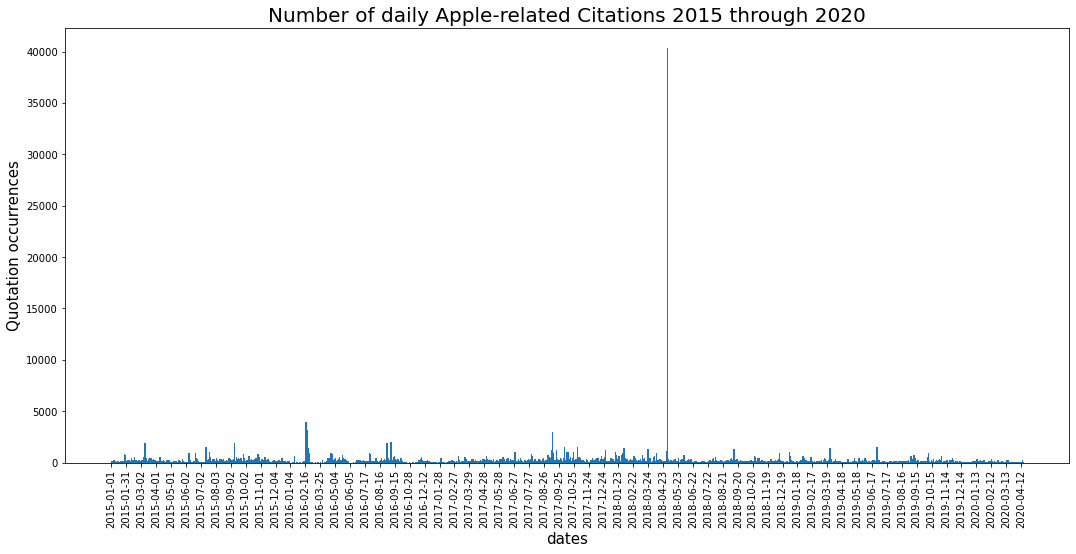

In [73]:
# Create plot to see the Apple-related quotes through the years
time = df.groupby(['date_clean']).sum().index
quote_num = df.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time,quote_num,width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
plt.show()

We see a massive spike close to the date 2018-04-23, which seems rather suspicious. Let's investigate this further, by finding the particular quote and print its information.

In [74]:
# Print info about outlier quote
print(f"Quote occurrences: {df.loc[df.numOccurrences == df.numOccurrences.max()].numOccurrences.item()} ")
print(f"Quote: {df.loc[df.numOccurrences == df.numOccurrences.max()].quotation.item()}")

Quote occurrences: 39978 
Quote: Fortnite for iPhone is something of a gem in terms of content and its free-to-play structure.


It seems unlikely that such a generic quote has such a high occurrence number. There is the possibility that the quote originates from a viral tweet or advertisement, however, googling the quote yields no results. We will thus regard this as an extreme outlier for now, and investigate it further by comparing to the original data set in Milestone 3. 

In [77]:
# Drop outlier
df = df.drop(df.loc[df.numOccurrences == 39978].index)

Now that the outlier has been dropped, let's take a look at the plot again. 

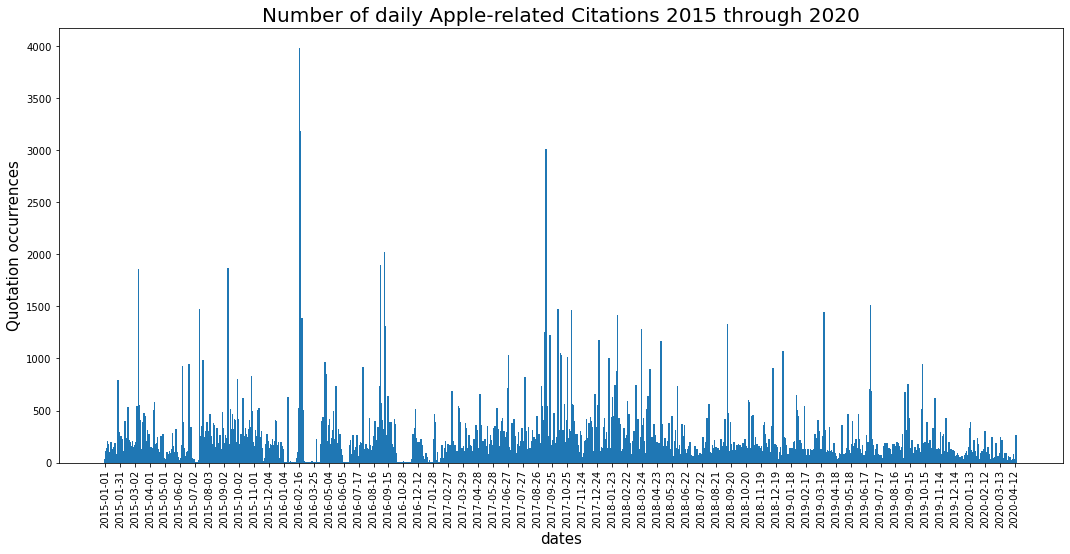

In [78]:
# Create plot to see the Apple-related quotes through the years (without outlier)
time = df.groupby(['date_clean']).sum().index
quote_num = df.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time,quote_num,width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
plt.show()

#Plots the dates after adding the 
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time[20000:30000],quote_num.iloc[20000:30000],width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
ap=ax.scatter(quote_num[time.isin(apple_event_dates_str)].index.list,quote_num[time.isin(apple_event_dates_str)], c="r", s=100, zorder=3, label='Apple events')
plt.show()

ConversionError: Failed to convert value(s) to axis units: Index(['2015-01-01', '2015-01-31', '2015-03-02', '2015-04-01', '2015-05-01',
       '2015-06-02', '2015-07-02', '2015-08-03', '2015-09-02', '2015-10-02',
       '2015-11-01', '2015-12-04', '2016-01-04', '2016-02-16', '2016-03-25',
       '2016-05-04', '2016-06-05', '2016-07-17', '2016-08-16', '2016-09-15',
       '2016-10-28', '2016-12-12', '2017-01-28', '2017-02-27', '2017-03-29',
       '2017-04-28', '2017-05-28', '2017-06-27', '2017-07-27', '2017-08-26',
       '2017-09-25', '2017-10-25', '2017-11-24', '2017-12-24', '2018-01-23',
       '2018-02-22', '2018-03-24', '2018-04-23', '2018-05-23', '2018-06-22',
       '2018-07-22', '2018-08-21', '2018-09-20', '2018-10-20', '2018-11-19',
       '2018-12-19', '2019-01-18', '2019-02-17', '2019-03-19', '2019-04-18',
       '2019-05-18', '2019-06-17', '2019-07-17', '2019-08-16', '2019-09-15',
       '2019-10-15', '2019-11-14', '2019-12-14', '2020-01-13', '2020-02-12',
       '2020-03-13', '2020-04-12'],
      dtype='object', name='date_clean')

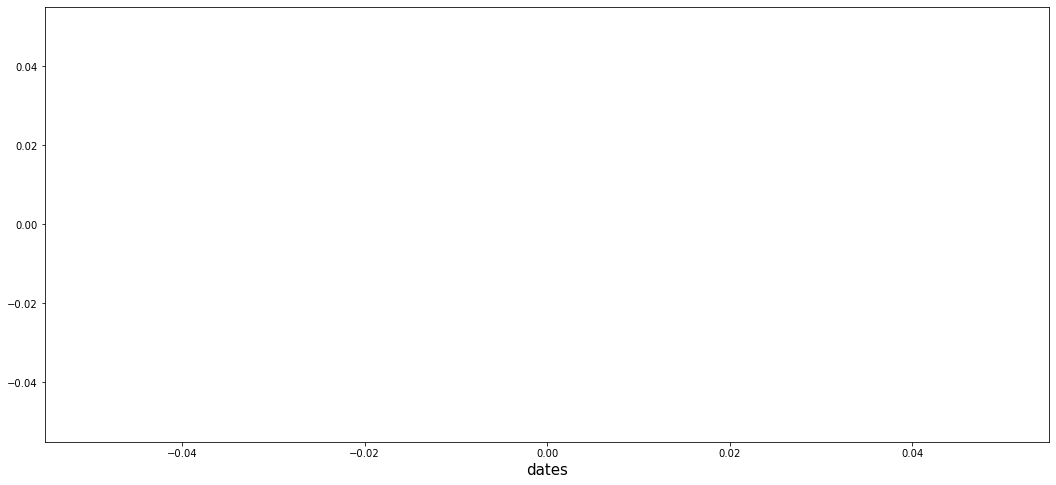

In [130]:
# Match quoteOccurrences to apple events
#apple_event_and_quote_data=df[df.iloc[20000:30000].date_clean.isin(apple_event_dates_str)]
#plt.scatter(quote_num[time.isin(apple_event_dates_str)].index,quote_num[time.isin(apple_event_dates_str)])

#Plots the dates after adding the 
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(time[20000:30000],quote_num.iloc[20000:30000],width=3, align='center')
ax.set_xlabel("dates",size=15)
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=20)
ap=ax.scatter(time[time.isin(apple_event_dates_str)],quote_num[time.isin(apple_event_dates_str)], c="r", s=100, zorder=3, label='Apple events')
plt.show()


## 3. How does the distribution of quote occurences look?

Text(0.5, 1.0, 'Distribution of quote occurrences (Occurrences capped at 60)')

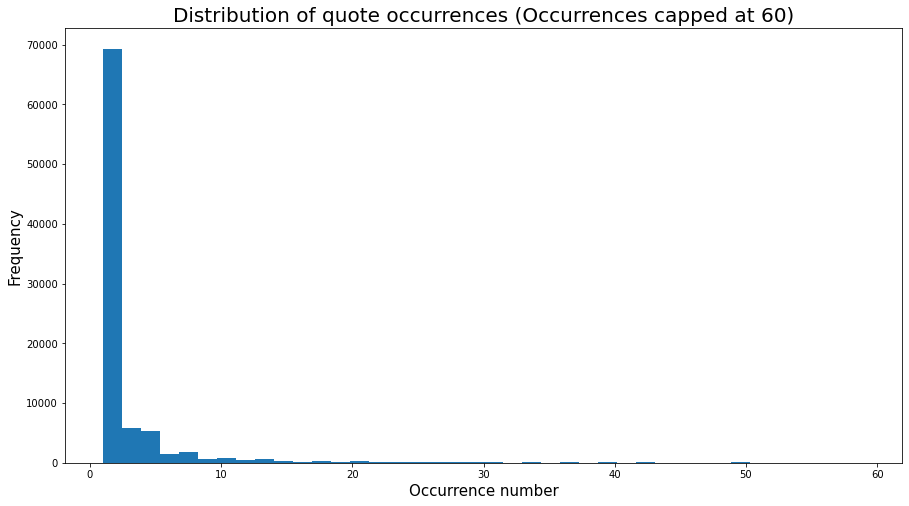

In [45]:
fig,ax = plt.subplots(figsize=(15,8))
ax.hist(df.numOccurrences[df.numOccurrences < 60],bins=40,);
ax.set_xlabel("Occurrence number",size=15)
ax.set_ylabel("Frequency",size=15)
ax.set_title("Distribution of quote occurrences (Occurrences capped at 60)",size=20)

## 4. How does the most frequent speakers vary throughout the year?

In [46]:
#Extracting dataset and formatting date
quotes_per_date = df.copy()
quotes_per_date['date'] = quotes_per_date['date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))

#Extracting dataset and formatting date to show only month
quotes_per_month = df.copy()
quotes_per_month['date'] = quotes_per_month['date'].apply(lambda x: dt.datetime.strptime(x[:7], '%Y-%m'))

In [47]:
#Pivoting table such that each column is a speaker and index is date
#Merging Donald Trump quotations and dropping None as well
quotes_per_date = quotes_per_date.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0, aggfunc=np.sum)
quotes_per_date['Donald Trump'] = quotes_per_date['Donald Trump'] + \
                                  quotes_per_date['President Donald Trump'] + \
                                  quotes_per_date['President Trump']
quotes_per_date.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

quotes_per_month = quotes_per_month.pivot_table('numOccurrences', ['date'], 'speaker', fill_value=0, aggfunc=np.sum)
quotes_per_month['Donald Trump'] = quotes_per_month['Donald Trump'] + \
                                   quotes_per_month['President Donald Trump'] + \
                                   quotes_per_month['President Trump']
quotes_per_month.drop(['None', 'President Donald Trump', 'President Trump'], axis=1, inplace=True)

In [49]:
#Cummulative representation of quotes
cummulative_quotes_per_date = quotes_per_date.cumsum(axis=0)
cummulative_quotes_per_month = quotes_per_month.cumsum(axis=0)


### Investigation of frequent speakers


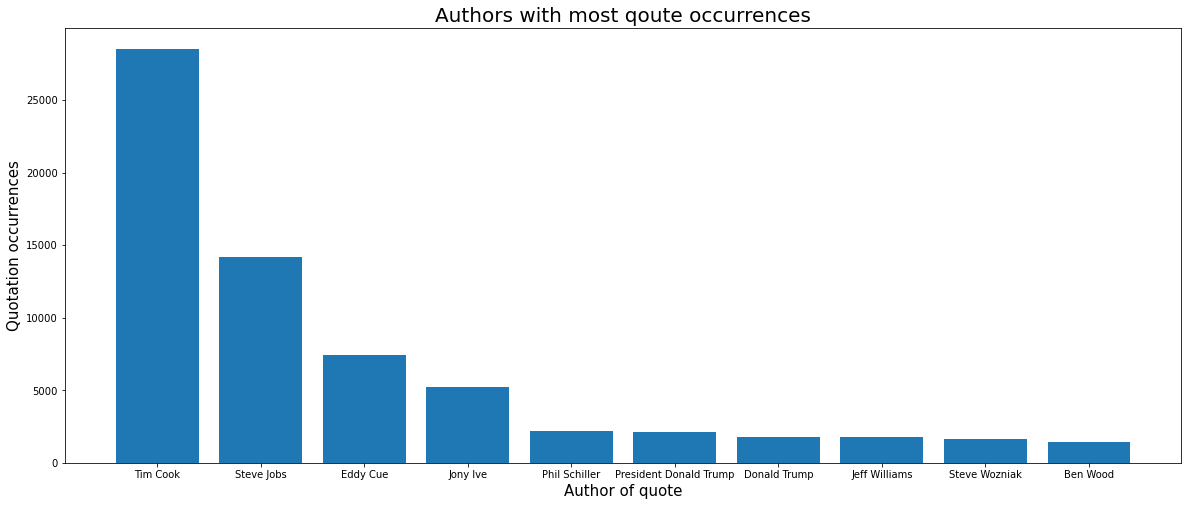

In [59]:
top_speakers = df.loc[df.speaker != 'None'].groupby(by=['speaker']).sum().sort_values(by='numOccurrences',ascending=False).reset_index()
fig,ax = plt.subplots(figsize=(20,8))
ax.bar(top_speakers.speaker[:10],top_speakers.numOccurrences[:10])
ax.set_xlabel("Author of quote",size=15)
ax.set_ylabel("Quotation occurrences",size=15)
#plt.xticks(top_speakers.speaker1[:10],rotation=90)
ax.set_title("Authors with most qoute occurrences",size=20)
plt.show()

Text(0, 0.5, 'Number of quotations')

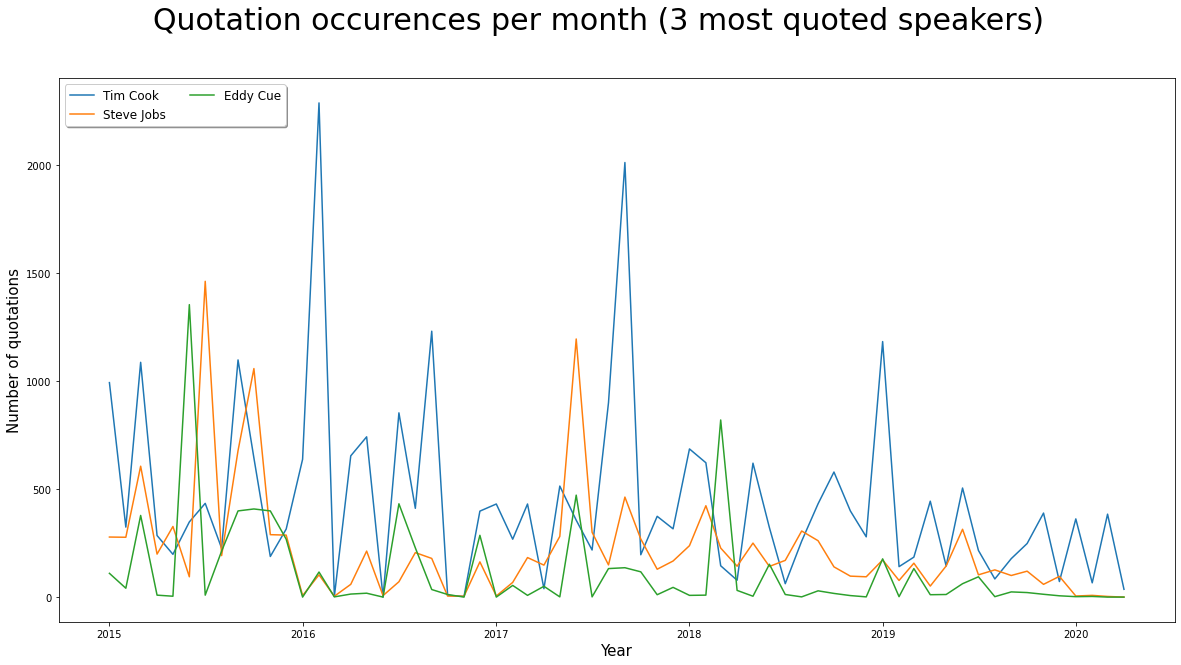

In [58]:
#Extract the 3 most frequent speakers
top_quoters = quotes_per_month.sum(axis=0).nlargest(3).index

#Extracting these from week dataset
top_quotes_per_month = quotes_per_month[top_quoters]
cummulative_top_quotes_per_month = cummulative_quotes_per_month[top_quoters]

fig = plt.figure(figsize=(20, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(top_quotes_per_month.index, top_quotes_per_month[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Quotation occurences per month (3 most quoted speakers)', fontsize=30)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)


### Normal Plot

### Cummulative plot

Text(0, 0.5, 'Number of quotations')

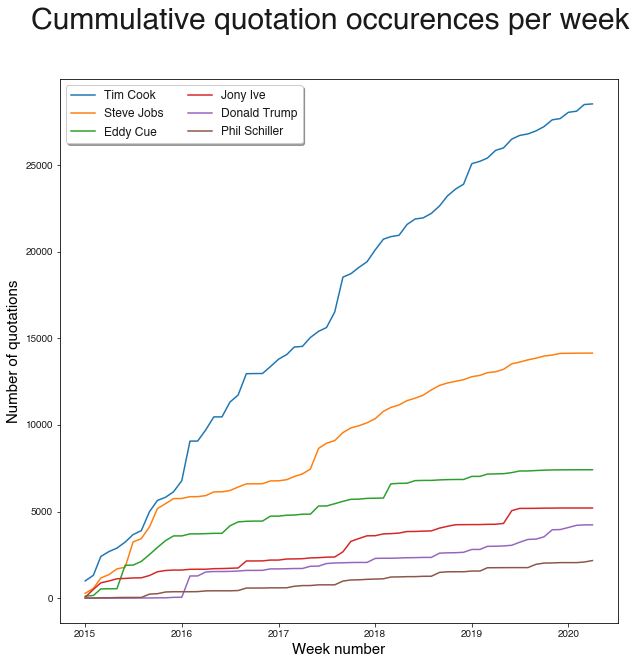

In [73]:
fig = plt.figure(figsize=(10, 10))
labels=[]
for quoter in top_quoters:
    plt.plot(cummulative_top_quotes_per_month.index, cummulative_top_quotes_per_month[quoter])
    labels.append(quoter)

plt.legend(labels, ncol=2, loc='upper left', fancybox=True, shadow=True,
           fontsize=12)
fig.suptitle('Cummulative quotation occurences per week', fontsize=30)
plt.xlabel('Week number', fontsize=15)
plt.ylabel('Number of quotations', fontsize=15)



We immediately recognize the big names *Donald Trump*, *Tim Cook* and *Steve Jobs*. Although Steve Jobs has passed away, he frequently gets quoted in the media. In addition, *Jony Ive* is the former chief designer of Apple, whom left the company in 2019. *Eddy Cue* is the senior vice president of Apple, reporting to Tim Cook. So it is natural that these names appear. *Phil Schiller* is also an apple executive. We initially observe that the most frequent speakers of Apple are indeed a part of the company. Not very shocking.

### Code for making a .mp4 file with the animation

In [60]:
# Determine whether to make mp4 visualization of most quoted speakers
create_mp4 = False
if create_mp4:
    import bar_chart_race as bcr
    quotes_per_date_plot = bcr.bar_chart_race(cummulative_quotes_per_month, filename='quotes_per_date_plot.mp4',
                                          n_bars=10, filter_column_colors=True, period_length=1000, steps_per_period=20,
                                          title='Most frequently quoted people', period_fmt='%B %Y',    
                                          shared_fontdict={'family' : 'Helvetica', 'color' : '.1'}
)

---

# Initial analysis of Apple stock and events

Lets start by loading the stock data and quarterly earnings for Apple Inc. 

In [101]:
#Load stock data
stock_data=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')

In [103]:
#Create a new dataframe only containing stock data from Apple event-days
apple_event_and_stock_data=stock_data[stock_data.Date.isin(apple_event_dates_str)]
apple_event_and_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
44,2015-03-09,31.990000,32.392502,31.264999,31.785000,28.890726,354114000
109,2015-06-10,31.980000,32.334999,31.962500,32.220001,29.408445,156349200
172,2015-09-09,28.440001,28.504999,27.442499,27.537500,25.248312,340043200
305,2016-03-21,26.482500,26.912500,26.285000,26.477501,24.512644,142010800
365,2016-06-15,24.455000,24.602501,24.257500,24.285000,22.619728,117780800


In [105]:
#Load quarterly earnings data: https://finance.yahoo.com/calendar/earnings?symbol=AAPL
quarterly_earnings=pd.read_excel('./data/Earnings_Apple.xlsx')
quarterly_earnings=quarterly_earnings.drop(index=[0,1,2,3,4,5,6,7])

#Change the format of the Earnings Date column to be able to compare it with the Stock dataframe
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: x.replace(", 12 AMEST", "").replace(",", ""))
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: dt.datetime.strptime(x, "%b %d %Y").strftime("%Y-%m-%d"))

#
apple_earnings_and_stock_data=stock_data[stock_data.Date.isin(quarterly_earnings["Earnings Date"])]
quarterly_earnings.head(10)

,Symbol,Company,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
8,AAPL,Apple Inc.,2020-10-29,0.7,0.73,+4.29
9,AAPL,Apple Inc.,2020-07-30,0.51,0.65,+26.22
10,AAPL,Apple Inc.,2020-04-30,0.56,0.64,+12.92
11,AAPL,Apple Inc.,2020-01-28,1.14,1.25,+9.76
12,AAPL,Apple Inc.,2019-10-30,0.71,0.76,+6.76
13,AAPL,Apple Inc.,2019-07-30,0.53,0.55,+3.81
14,AAPL,Apple Inc.,2019-04-30,0.59,0.62,+4.24
15,AAPL,Apple Inc.,2019-01-29,1.04,1.05,+0.29
16,AAPL,Apple Inc.,2018-11-01,0.7,0.73,+4.6
17,AAPL,Apple Inc.,2018-07-31,2.18,2.34,+7.29


In [106]:
#Create a new dataframe only containing stock data from Apple event-days
apple_event_and_stock_data=stock_data[stock_data.Date.isin(apple_event_dates_str)]
apple_event_and_stock_data.head()

apple_earnings_and_stock_data=stock_data[stock_data.Date.isin(quarterly_earnings["Earnings Date"])]

## Add data to dates where the stock market is closed

In [107]:
stock_data_with_closed_days=stock_data.copy()
idx = pd.date_range('2015-01-02', '2020-12-31')
stock_data_with_closed_days.index = pd.DatetimeIndex(stock_data.Date)
stock_data_with_closed_days = stock_data_with_closed_days.reindex(idx, method='ffill').reset_index()

In [108]:
stock_data_with_closed_days.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,2015-01-02,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
1,2015-01-03,2015-01-02,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
2,2015-01-04,2015-01-02,27.8475,27.860001,26.837500,27.332500,24.745993,212818400
3,2015-01-05,2015-01-05,27.0725,27.162500,26.352501,26.562500,24.048859,257142000
4,2015-01-06,2015-01-06,26.6350,26.857500,26.157499,26.565001,24.051128,263188400


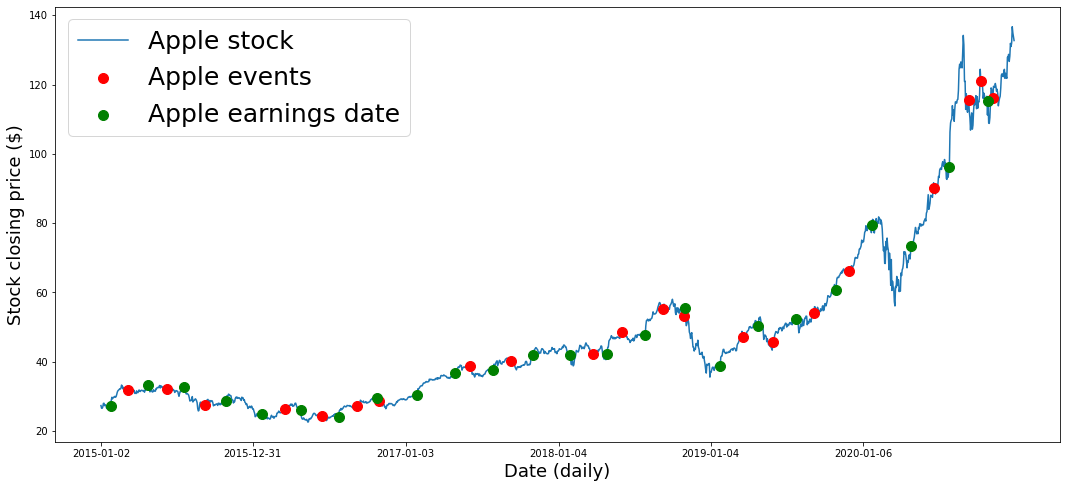

In [109]:
#Plots the dates after adding the 
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(stock_data_with_closed_days.Date,stock_data_with_closed_days.Close, label='Apple stock')
ax.set_xlabel("Date (daily)", size=18)
ax.set_ylabel('Stock closing price ($)', size=18)
plt.xticks(stock_data_with_closed_days.Date[::366])
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c="g", s=100, zorder=3, label='Apple earnings date')
ax.legend(prop={'size': 25})
plt.show()

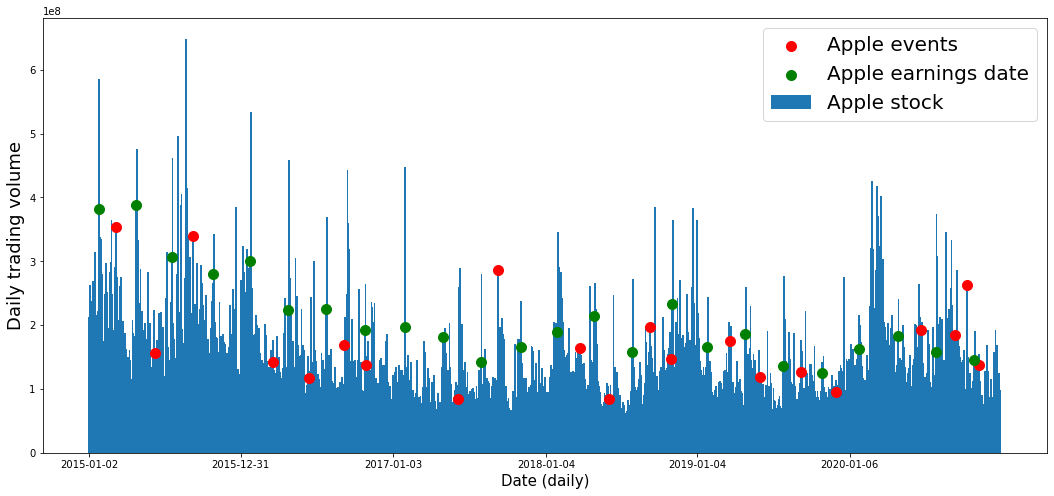

In [110]:
#Plot each trading day and its volume
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(stock_data_with_closed_days.Date,stock_data_with_closed_days.Volume, label='Apple stock', width=3, align='center')
ax.set_xlabel("Date (daily)",size=15)
ax.set_ylabel('Daily trading volume', size=18)
plt.xticks(stock_data_with_closed_days.Date[::366])
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Volume, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Volume, c="g", s=100, zorder=3, label='Apple earnings date')
ax.legend(prop={'size': 20})
plt.show()

## Group by week

In [112]:
stock_data_weekly_average=stock_data.copy()

#Create a new dataframe containing the weekly average of the stock price
#https://stackoverflow.com/questions/45281297/group-by-week-in-pandas/45281439
stock_data_weekly_average.Date = pd.to_datetime(stock_data_weekly_average.Date) - pd.to_timedelta(7, unit='d')
stock_data_weekly_average = stock_data_weekly_average.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')

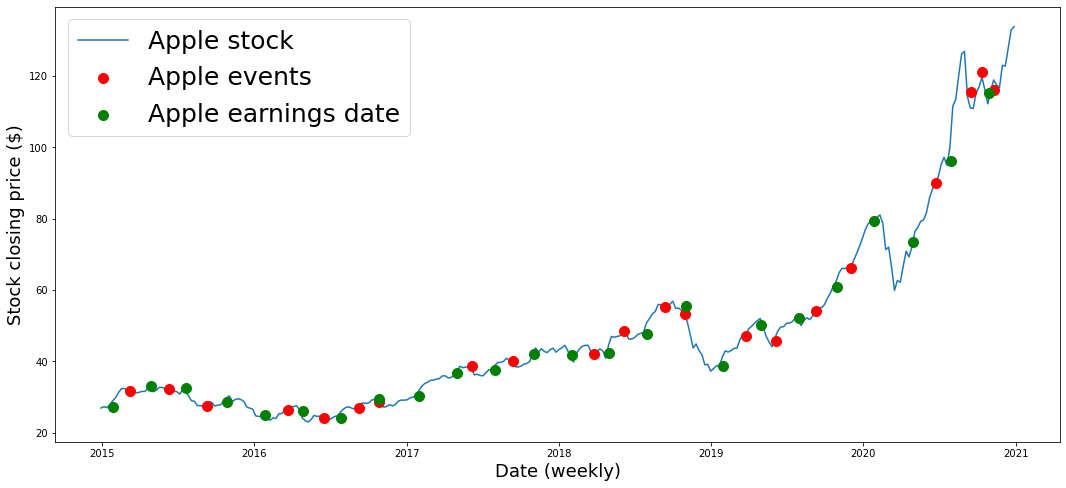

In [113]:
#Plots the weekly average
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(stock_data_weekly_average.Date,stock_data_weekly_average.Close, label='Apple stock')
apple_events=ax.set_xlabel("Date (weekly)",size=18)
ax.set_ylabel('Stock closing price ($)', size=18)
ax.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c="r", s=100, zorder=3, label='Apple events')
ax.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c="g", s=100, zorder=3, label='Apple earnings date')
ax.legend(prop={'size': 25})
plt.show();

In [114]:
apple_event_and_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
44,2015-03-09,31.990000,32.392502,31.264999,31.785000,28.890726,354114000
109,2015-06-10,31.980000,32.334999,31.962500,32.220001,29.408445,156349200
172,2015-09-09,28.440001,28.504999,27.442499,27.537500,25.248312,340043200
305,2016-03-21,26.482500,26.912500,26.285000,26.477501,24.512644,142010800
365,2016-06-15,24.455000,24.602501,24.257500,24.285000,22.619728,117780800
